# Installations

In [5]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6 MB 25.2 MB/s 
     |████████████████████████████████| 1.4 MB 40.4 MB/s 
     |████████████████████████████████| 926 kB 32.0 MB/s 
     |████████████████████████████████| 382 kB 38.7 MB/s 


# Libraries

In [54]:
# Load Libraries

import torch_geometric
from torch_geometric.datasets import Planetoid

import os
import numpy as np
from time import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# Data Loading

In [7]:
# Load Dataset

dataset = Planetoid(root="tutorial1",name= "Cora")

Processing...
Done!


In [8]:
# Dataset Characterstics

print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

Cora()
number of graphs:		 1
number of classes:		 7
number of node features:	 1433
number of edge features:	 0


In [14]:
# Dataset Structure

dataset.data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [21]:
# Dataset Shapes

print(f"""Edge Index:
      - {dataset.data.edge_index.shape}
      - {dataset.data.edge_index.numpy()}
""")

print(f"""Train Mask:
      - {dataset.data.train_mask.shape}
      - {dataset.data.train_mask.numpy()}
""")

print(f"""Tensor X:
      - {dataset.data.x.shape}
      - {dataset.data.x.numpy()}
""")

print(f"""Tensor Y:
      - {dataset.data.y.shape}
      - {dataset.data.y.numpy()}
""")

Edge Index:
      - torch.Size([2, 10556])
      - [[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]

Train Mask:
      - torch.Size([2708])
      - [ True  True  True ... False False False]

Tensor X:
      - torch.Size([2708, 1433])
      - [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Tensor Y:
      - torch.Size([2708])
      - [3 4 4 ... 3 3 3]



In [23]:
# Select Data

data = dataset[0]

# Modelling

In [27]:
# Use GPU

GPU = False

In [28]:
# Set Device

device = 'cuda' if torch.cuda.is_available() and GPU else 'cpu'
device

'cpu'

In [25]:
# Define Grah Convolutional Netowork Class

class GCN(torch.nn.Module):
    def __init__(self, n_features, n_classes, **kwargs):
        super(GCN, self).__init__(**kwargs)
        
        self.n_features = n_features
        self.n_classes = n_classes
        self.conv = SAGEConv(n_features, n_classes, aggr="max")

    def forward(self, x, edge_idx):
        x = self.conv(x, edge_idx)
        return F.log_softmax(x, dim=1)

In [52]:
# Instantiate Model
model = GCN(dataset.num_features, dataset.num_classes)

# Put Model and Data on Device
model.to(device)
data.to(device)

# Instantiate Optimizer
adam = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [53]:
# Define Train and Evalaution Subroutine

EPOCHS = 150
PATIENCE = 5
history = {"train-loss": [np.inf], "val-loss": [np.inf], "train-accuracy": [0], "val-accuracy": [0]}

min_loss = np.inf
es_counter = 0

for epoch in range(EPOCHS):
    tick = time()

    # Custom Train Loop
    model.train()
    adam.zero_grad()
    logits = model.forward(data.x, data.edge_index)
    train_loss =  F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    adam.step()
    history["train-loss"].append(train_loss.item())

    # Custom Evaluation Loop
    model.eval()
    logits = model.forward(data.x, data.edge_index)
    val_loss =  F.nll_loss(logits[data.val_mask], data.y[data.val_mask])
    history["val-loss"].append(val_loss.item())
    for mask_name in ['train', 'val']:
        _, mask = next(data(f"{mask_name}_mask"))
        pred = logits[mask].max(dim=1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        history[f"{mask_name}-accuracy"].append(acc)

    tock = time()

    # Early Stopping
    if min_loss < val_loss:
        es_counter += 1
    else:
        es_counter = 0
    
    if es_counter >= PATIENCE:
        print("Validation Loss Increasing. Early Stopping !!!")
        break
    
    # Print Results
    if (epoch)%10 == 0:
        print(f"""Epcohs: {epoch:03}/{EPOCHS}
    - Train Loss:{history["train-loss"][-1]: 0.6f} \t Train Accuracy: {history["train-accuracy"][-1]: 0.6f}
    - Valid Loss:{history["val-loss"][-1]: 0.6f} \t Valid Accuracy: {history["val-accuracy"][-1]: 0.6f}
    - Turnaround Time: {tock-tick: 0.6f} sec
        """)

    # Update Minimum Loss
    min_loss = min(*history["val-loss"])

Epcohs: 0000/150
    - Train Loss: 1.953028 	 Train Accuracy:  0.942857
    - Valid Loss: 1.731292 	 Valid Accuracy:  0.512000
    - Turnaround Time:  0.548314 sec
        
Epcohs: 0010/150
    - Train Loss: 0.050249 	 Train Accuracy:  1.000000
    - Valid Loss: 0.984952 	 Valid Accuracy:  0.728000
    - Turnaround Time:  0.511488 sec
        
Epcohs: 0020/150
    - Train Loss: 0.006670 	 Train Accuracy:  1.000000
    - Valid Loss: 0.942327 	 Valid Accuracy:  0.718000
    - Turnaround Time:  0.506097 sec
        
Epcohs: 0030/150
    - Train Loss: 0.002849 	 Train Accuracy:  1.000000
    - Valid Loss: 0.937275 	 Valid Accuracy:  0.708000
    - Turnaround Time:  0.501790 sec
        
Epcohs: 0040/150
    - Train Loss: 0.002219 	 Train Accuracy:  1.000000
    - Valid Loss: 0.930857 	 Valid Accuracy:  0.716000
    - Turnaround Time:  0.499036 sec
        
Epcohs: 0050/150
    - Train Loss: 0.002288 	 Train Accuracy:  1.000000
    - Valid Loss: 0.923205 	 Valid Accuracy:  0.726000
    - Tu

# Visualize Results

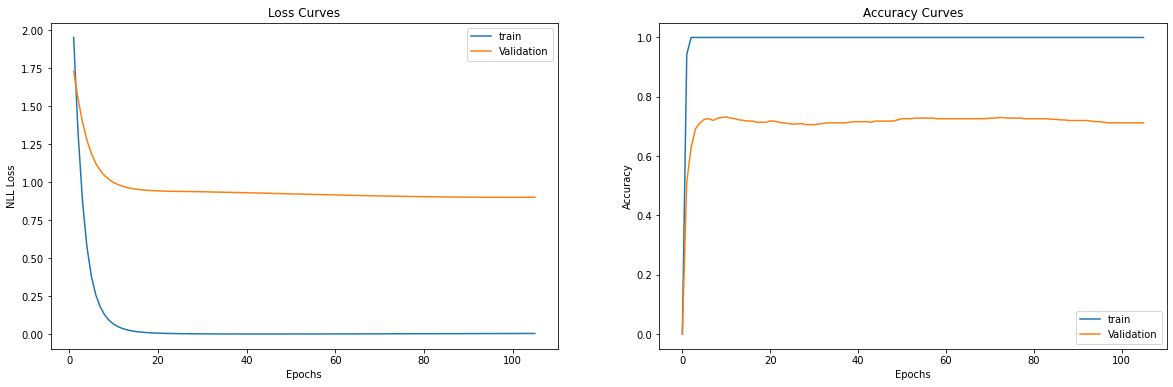

In [55]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history["train-loss"], label="train")
plt.plot(history["val-loss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("NLL Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train-accuracy"], label="train")
plt.plot(history["val-accuracy"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()